In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [140]:
from sklearn.manifold import Isomap
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import pairwise_distances, f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, roc_curve, auc, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


### GET ISOMAP FEATURES

In [3]:
sulci_distance_matrix = np.load('.././sulci_distance_matrix.npy')
sulci_reg_keys = np.load('.././sulci_reg_keys.npy')
np.shape(sulci_distance_matrix)

(572, 572)

In [4]:
ismap = Isomap(n_components=17, n_neighbors=14, n_jobs=-1)
sdm_transformed = ismap.fit_transform(sulci_distance_matrix)
print(sdm_transformed.shape)

(572, 17)


In [5]:
sulci_meta_str = [''.join(i[0].split('-')[:2]) for i in sulci_reg_keys]
subj_id = [i.split('_')[1] for i in sulci_meta_str]
subj_id = [x[:3] + '-' + x[3:] for x in subj_id]
side = [i.split('_')[0] for i in sulci_meta_str]

isomap_features = pd.DataFrame(sdm_transformed, columns=[f'isomap_{i}' for i in range(sdm_transformed.shape[1])])
isomap_features['subject_id'] = subj_id
isomap_features['side'] = side

isomap_features.head()

,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,isomap_8,isomap_9,isomap_10,isomap_11,isomap_12,isomap_13,isomap_14,isomap_15,isomap_16,subject_id,side
0,9.688326,-0.953670,-0.539174,-1.875211,-1.513877,0.044964,3.342995,-1.087683,-1.583092,-1.259045,1.994612,-0.614083,3.568669,-2.927934,-0.422573,1.461781,3.121010,sub-via003,left
1,14.372313,-2.251952,-3.152609,-0.080369,-5.992478,-0.792929,3.719239,-4.538002,-4.452302,1.816918,-0.960385,2.932196,-1.862068,-0.675507,-0.875355,0.245438,-3.009046,sub-via003,right
2,1.107278,-0.755399,-3.654512,-5.042098,-1.537551,-2.256313,6.692906,3.997100,-0.590491,-3.392920,0.223568,-3.420061,1.949864,3.084412,-3.318330,-0.377937,2.244742,sub-via004,left
3,6.269484,-1.159266,-2.753461,-0.480566,-4.779552,0.657374,5.456644,0.893196,-3.477424,-2.391934,2.810426,2.628400,3.298249,-1.955650,0.422064,0.155804,2.440332,sub-via004,right
4,-0.189985,-7.977296,4.868147,3.230779,-3.123908,-4.113416,-1.843032,5.329172,-5.001592,-2.208233,2.231607,-2.519707,0.988928,-2.047101,-1.121655,-0.172652,0.853392,sub-via005,left


### LOAD EDA FEATURES

In [79]:
via11_scQA = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/QA_centralSulcus_lkj.xlsx')[['subjects', 'sites', 'vis_QA', 'editted']]
via11_scQA = via11_scQA[~via11_scQA.subjects.isna()]
via11_scQA = via11_scQA.set_index('subjects')

via11_demo = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/VIA11_fmriflanker_info_database_2021jan25.xlsx')
via11_demo = via11_demo[via11_demo.mp2rage_exists == 1].drop(columns=['in_via11', 'stormdb'])
via11_demo['subjects'] = [f'sub-via{x:03d}' for x in via11_demo.via_id]
via11_demo = via11_demo[~via11_demo.subjects.isna()]
via11_demo = via11_demo[via11_demo.subjects.isin(via11_scQA.index.values)]
via11_demo = via11_demo.set_index('subjects')

for subject in via11_demo.index.values:
    # via11_demo.loc[subject, 'site'] = via11_scQA.loc[subject, 'sites']
    via11_demo.loc[subject, 'vis_QA'] = via11_scQA.loc[subject, 'vis_QA']
    via11_demo.loc[subject, 'editted'] = via11_scQA.loc[subject, 'editted']
    
via11_demo

,via_id,site,group,mri_age,sex,handedness,tanner,cbcl_total,cbcl_external,cbcl_internal,...,flanker_behav_deltaRT_3sd,no_sMRI,no_flanker_fMRI,Braces,neurological disorder,in_flanker_behav,in_flanker_analysis,comment,vis_QA,editted
subjects,,,,,,,,,,,,,,,,,,,,,
sub-via003,3,1.0,3.0,12.188912,0.0,3.0,2.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
sub-via004,4,1.0,3.0,11.764545,0.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,1.0,0.0
sub-via005,5,1.0,3.0,11.493498,0.0,3.0,2.0,9.0,2.0,3.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,1.0,0.0
sub-via010,10,2.0,2.0,11.718001,1.0,2.0,2.0,62.0,14.0,13.0,...,0.0,0.0,0.0,0,0,0.0,0.0,wrong e-prime,2.0,1.0
sub-via013,13,2.0,3.0,12.287474,0.0,2.0,3.0,7.0,2.0,2.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-via517,517,2.0,3.0,11.641342,1.0,3.0,3.0,4.0,0.0,3.0,...,0.0,1.0,1.0,0,0,0.0,0.0,stim. Com. Malfunction,1.0,0.0
sub-via518,518,1.0,3.0,12.353183,1.0,3.0,2.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0
sub-via519,519,2.0,3.0,12.533881,1.0,3.0,4.0,11.0,2.0,3.0,...,0.0,0.0,0.0,0,0,1.0,1.0,NaN,2.0,0.0


In [82]:
bv_good_subj = via11_demo[via11_demo.vis_QA == 1].index.values

In [37]:
# cs_feat = pd.read_pickle('../data/bvisa_subject_features.pkl')

In [38]:
# def select_morphofeatures(df:pd.DataFrame,
#                           features:list[str] = ['label',
#                                                 'side',
#                                                 'surface_talairach',
#                                                 'maxdepth_talairach',
#                                                 'meandepth_talairach',
#                                                 'hull_junction_length_talairach',
#                                                 'GM_thickness', 'opening'], 
#                           sulci: list[str] = ['S.C.'],
#                           side: str = 'r'):
#     """_summary_

#     Args:
#         df (pd.DataFrame): DataFrame with morphological features of a subject
#         features (list[str], optional): List of features to use. Defaults to ['label', 'side', 'surface_talairach', 'maxdepth_talairach', 'meandepth_talairach'].
#         sulci (list[str], optional): List of sulci to use. Defaults to ['S.C.'].
#         side (str, optional): Which sides of sulci to use as features.
#             Could be 'l' or 'r' to extract features only from left or right
#             sulci or 'both' to extract features from both. Defaults to 'r'.

#     Returns:
#         np.ndarray: 1D array of features
#         np.ndarray: 1D array of feature names
#     """
#     # filter by selected sulci
#     features = df[df.label.isin(sulci)][features]
#     if len(sulci) == 1:
#         features = features.drop(columns=['label'])
#     else:
#         raise NotImplementedError('Only one sulcus is supported for now')
    
#     # get feature names
#     if side == 'l' or side =='r':
#         feature_names = [f'{side}_{c}' for c in features.columns.values]
#     else:
#         feature_names = [f'{s}_{c}' for s in ['l', 'r']  for c in features.columns.values if c != 'side']
    
#     # transform features into an array
#     if side == 'l':
#         features = features[features.side == 'left'].drop(columns=['side'])
#     elif side == 'r':
#         features = features[features.side == 'right'].drop(columns=['side'])
#     elif side == 'both':
#         features = features.drop(columns=['side'])
#     else:
#         raise ValueError('side should be either "l", "r" or "both"')
#     features = features.values.flatten()
    
    
#     return features, feature_names
    

In [39]:
# medial_axis_L_depth_matrix = np.stack([cs_feat[x]['medial_axis_L']['depth'].values for x in cs_feat.keys()])
# medial_axis_R_depth_matrix = np.stack([cs_feat[x]['medial_axis_R']['depth'].values for x in cs_feat.keys()])
# depth_profile_L_depth_matrix = np.stack([cs_feat[x]['depth_profile_L']['depth'].values for x in cs_feat.keys()])
# depth_profile_R_depth_matrix = np.stack([cs_feat[x]['depth_profile_R']['depth'].values for x in cs_feat.keys()])

# medial_axis_L_profile_matrix = np.stack([cs_feat[x]['medial_axis_L']['profile'].values for x in cs_feat.keys()])
# medial_axis_R_profile_matrix = np.stack([cs_feat[x]['medial_axis_R']['profile'].values for x in cs_feat.keys()])
# depth_profile_L_profile_matrix = np.stack([cs_feat[x]['depth_profile_L']['profile'].values for x in cs_feat.keys()])
# depth_profile_R_profile_matrix = np.stack([cs_feat[x]['depth_profile_R']['profile'].values for x in cs_feat.keys()])


In [40]:
# FA_number_components = 3

# fa = FactorAnalysis(n_components=FA_number_components) # OR CHANGE TO PCA
# medial_axis_L_depth_fa = fa.fit_transform(medial_axis_L_depth_matrix)
# medial_axis_R_depth_fa = fa.fit_transform(medial_axis_R_depth_matrix)
# depth_profile_L_depth_fa = fa.fit_transform(depth_profile_L_depth_matrix)
# depth_profile_R_depth_fa = fa.fit_transform(depth_profile_R_depth_matrix)
# medial_axis_L_profile_fa = fa.fit_transform(medial_axis_L_profile_matrix)
# medial_axis_R_profile_fa = fa.fit_transform(medial_axis_R_profile_matrix)
# depth_profile_L_profile_fa = fa.fit_transform(depth_profile_L_profile_matrix)
# depth_profile_R_profile_fa = fa.fit_transform(depth_profile_R_profile_matrix)


In [41]:
# morph_feat = pd.DataFrame(np.stack([select_morphofeatures(cs_feat[x]['morphology'], side='both')[0] for x in cs_feat.keys()]),
#                           columns=select_morphofeatures(cs_feat['sub-via003']['morphology'], side='both')[1], index=[x for x in cs_feat.keys()])

# profile_feat = {'L_medial_axis_depth':medial_axis_L_depth_fa,
#                 'R_medial_axis_depth':medial_axis_R_depth_fa,
#                 'L_depth_profile_depth':depth_profile_L_depth_fa,
#                 'R_depth_profile_depth':depth_profile_R_depth_fa,
#                 'L_medial_axis_profile':medial_axis_L_profile_fa,
#                 'R_medial_axis_profile':medial_axis_R_profile_fa,
#                 'L_depth_profile_profile':depth_profile_L_profile_fa,
#                 'R_depth_profile_profile':depth_profile_R_profile_fa,
#             }

# for f in profile_feat.keys():
#     for fnum in range(FA_number_components):
#         morph_feat[f'{f}_{fnum}'] = profile_feat[f][:, fnum]

# morph_feat

In [42]:
# TARGET_FEAT = ['handedness', 'group', 'cbcl_total', 'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis']
# target_df = via11_demo[TARGET_FEAT]
# target_df

In [53]:
# eda_df = target_df.join(morph_feat).join(via11_demo[['mri_age', 'sex']])
# eda_df.to_pickle('../data/eda_df.pkl')

# Analyze ISOMAP Features

In [6]:
eda_df = pd.read_pickle('../data/eda_df.pkl')

Checking if we need to correct for age/sex

Test if the coordinates for any Isomap dimension correlated with `mri_age`, `sex` at acquisition, independently for each age-group but together for left and right sulci.

The resultant correlations (going up to 0.30 for dimension 1 at 30w PMA) confirmed the importance of correcting the dimension coordinates for PMA at MRI acquisition in each group, before conducting further analyses.

In [7]:
for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = isomap_features[isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in isomap_features.columns[:-2]:
        if abs(grp_df[id].corr(grp_df.mri_age)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with age in group {g}: {grp_df[id].corr(grp_df.mri_age)}')
        if abs(grp_df[id].corr(grp_df.sex)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with sex in group {g}: {grp_df[id].corr(grp_df.sex)}')

Correlation of ISOMAP feature isomap_5 with sex in group 3.0: -0.1272873516788543
Correlation of ISOMAP feature isomap_8 with sex in group 3.0: -0.17913057426703904
Correlation of ISOMAP feature isomap_11 with sex in group 3.0: -0.12732020422533022
Correlation of ISOMAP feature isomap_13 with sex in group 3.0: -0.10122081686511812
Correlation of ISOMAP feature isomap_16 with sex in group 3.0: -0.10748845932996756
Correlation of ISOMAP feature isomap_1 with age in group 2.0: 0.14028350243856713
Correlation of ISOMAP feature isomap_2 with age in group 2.0: -0.11435594762672059
Correlation of ISOMAP feature isomap_3 with sex in group 2.0: 0.11163840156876087
Correlation of ISOMAP feature isomap_6 with sex in group 2.0: -0.16516314930823925
Correlation of ISOMAP feature isomap_7 with age in group 2.0: -0.13062277207295503
Correlation of ISOMAP feature isomap_8 with age in group 2.0: -0.18412701089524636
Correlation of ISOMAP feature isomap_11 with age in group 2.0: -0.11887529821095778
Cor

### Perform correction of ISOMAP features for age at MRI acquisition and sex

Instead of using the raw Isomap coordinates for each dimension as the input for the subsequent analyses, we used their residuals after correction for age (that we centered on the age-group mean position on the Isomap in order to restore the information about inter-age-group positioning). The residuals were computed by solving, independently for each age-group, the linear model:
```
raw_isomap = alpha*age + beta + corrected_isompa
raw_isomap - corrected_ismap = alpha*age + beta

In [8]:
corrected_isomap_features = isomap_features.copy(deep=True)

for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = corrected_isomap_features[corrected_isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in corrected_isomap_features.columns[:-2]:
        lr = LinearRegression(fit_intercept=True)
        X = grp_df.mri_age.values.reshape(-1, 1)
        y = grp_df[id].values.reshape(-1, 1)
        lr.fit(X, y)
        y_pred = lr.predict(X)
        residuals = grp_df[id].values - y_pred.reshape(-1)
        corrected_isomap_features.loc[corrected_isomap_features.subject_id.isin(grp_subj), id] = residuals + corrected_isomap_features.loc[corrected_isomap_features.subject_id.isin(grp_subj), id].mean()

In [9]:
for g in eda_df.group.unique():
    grp_subj = eda_df[eda_df.group == g].index.values
    grp_df = corrected_isomap_features[corrected_isomap_features.subject_id.isin(grp_subj)]
    grp_df = grp_df.join(eda_df[['mri_age', 'sex']], on='subject_id')
    
    for id in isomap_features.columns[:-2]:
        if abs(grp_df[id].corr(grp_df.mri_age)) > 0.1:
            print(f'Correlation of ISOMAP feature {id} with age in group {g}: {grp_df[id].corr(grp_df.mri_age)}')
        # if abs(gr'Correlation of ISOMAP feature {id} with sex in group {g}: {grp_df[id].corr(grp_df.sex)}')p_df[id].corr(grp_df.sex)) > 0.1:
        #     print(f

Sex is balanced between groups

In [11]:
# for g in via11_demo.group.unique():
#     males = via11_demo[via11_demo.group == g].sex.value_counts()
#     print(f'Group {g}: \n{males/males.values.sum()}')

For each Isomap dimension, we investigated the relative positioning of the subgroups using two tests: a Wilcoxon signed-rank test to investigate whether the two age- or hemisphere-groups differed in positioning on a specific dimension (suggesting a difference in the shape of the sulci throughout development or between hemispheres), and a Spearman correlation to assess whether the two age- or hemisphere-groups showed correlated shape features (suggesting early and stable shape patterns throughout development or between the hemispheres). We conducted these tests between ages for each hemisphere (L30 vs L40, R30 vs R40), and between hemispheres at each age (L30 vs R30, L40 vs R40). Applying a correction for multiple comparisons with the Bonferroni approach would have led to a statistical threshold at 0.00125 for an alpha level at 0.05 because of the 40 tests performed (4 age-and-hemisphere-specific tests x 10 dimensions tested). However, as the Bonferroni method may be considered as too restrictive, we focused on results with p-values under the threshold computed for each age-and-hemisphere-specific test, thus only compensating for the number of dimensions, resulting in a statistical threshold at 0.005. Only the results with p-values below or in the same range as this corrected threshold are described in the Results section. The whole test results are available in Sup. Info., Table 3 for Wilcoxon signed rank tests and Table 4 for Spearman correlations.



In [12]:
eda_df_sided = []
sided_morph_feat = ['l_surface_talairach', 'l_maxdepth_talairach',
       'l_meandepth_talairach', 'l_hull_junction_length_talairach',
       'l_GM_thickness', 'l_opening', 'r_surface_talairach',
       'r_maxdepth_talairach', 'r_meandepth_talairach',
       'r_hull_junction_length_talairach', 'r_GM_thickness', 'r_opening',
       'L_medial_axis_depth_0', 'L_medial_axis_depth_1',
       'L_medial_axis_depth_2', 'R_medial_axis_depth_0',
       'R_medial_axis_depth_1', 'R_medial_axis_depth_2',
       'L_depth_profile_depth_0', 'L_depth_profile_depth_1',
       'L_depth_profile_depth_2', 'R_depth_profile_depth_0',
       'R_depth_profile_depth_1', 'R_depth_profile_depth_2',
       'L_medial_axis_profile_0', 'L_medial_axis_profile_1',
       'L_medial_axis_profile_2', 'R_medial_axis_profile_0',
       'R_medial_axis_profile_1', 'R_medial_axis_profile_2',
       'L_depth_profile_profile_0', 'L_depth_profile_profile_1',
       'L_depth_profile_profile_2', 'R_depth_profile_profile_0',
       'R_depth_profile_profile_1', 'R_depth_profile_profile_2']
not_sided_morh_feat = ['handedness', 'group', 'cbcl_total',
                       'cbcl_external', 'cbcl_internal',
                       'cgas', 'any_diagnosis', 'sex']
for i, row in eda_df.iterrows():
    lsulc = {k:v for k,v in row.items() if k in not_sided_morh_feat}
    rsulc = {k:v for k,v in row.items() if k in not_sided_morh_feat}
    lsulc['side'] = 'left'
    rsulc['side'] = 'right'
    lsulc['subject_id'] = i
    rsulc['subject_id'] = i
    for k, v in row.items():
       if k in sided_morph_feat:
           if k[:2].lower() == 'l_':
              lsulc[k[2:]] = v
           if k[:2].lower() == 'r_':
              rsulc[k[2:]] = v
    eda_df_sided.append(lsulc)
    eda_df_sided.append(rsulc)

In [13]:
eda_df_sided = pd.DataFrame(eda_df_sided)
# merge on both side and subject_id
all_feat_df = pd.merge(corrected_isomap_features, eda_df_sided,
                       on=['subject_id', 'side'],
                       how='inner')

In [14]:
corr = all_feat_df.drop(columns=['subject_id', 'side']).corr(numeric_only=False)
corr.style.background_gradient(cmap='coolwarm').set_precision(3)
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps
# plt.show()

/tmp/ipykernel_2929398/2432263808.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(3)


,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,isomap_8,isomap_9,isomap_10,isomap_11,isomap_12,isomap_13,isomap_14,isomap_15,isomap_16,handedness,group,cbcl_total,cbcl_external,cbcl_internal,cgas,any_diagnosis,sex,surface_talairach,maxdepth_talairach,meandepth_talairach,hull_junction_length_talairach,GM_thickness,opening,medial_axis_depth_0,medial_axis_depth_1,medial_axis_depth_2,depth_profile_depth_0,depth_profile_depth_1,depth_profile_depth_2,medial_axis_profile_0,medial_axis_profile_1,medial_axis_profile_2,depth_profile_profile_0,depth_profile_profile_1,depth_profile_profile_2
isomap_0,1.000,0.001,-0.008,-0.004,-0.002,0.004,0.002,0.004,-0.003,0.001,0.001,-0.003,0.001,0.005,-0.002,0.003,0.001,-0.030,-0.044,0.064,0.056,0.059,-0.049,-0.003,-0.023,-0.252,-0.033,-0.057,-0.221,0.030,-0.047,-0.029,0.116,0.117,0.006,-0.076,0.018,0.046,0.092,0.231,0.053,-0.052,0.063
isomap_1,0.001,1.000,0.007,0.002,-0.004,0.002,-0.002,0.007,0.009,-0.002,0.000,0.006,0.002,0.003,-0.006,0.001,-0.004,0.096,-0.006,-0.023,-0.004,-0.039,0.039,-0.052,-0.042,0.012,-0.010,-0.065,-0.015,0.029,-0.033,0.058,0.106,-0.048,0.059,0.051,-0.079,-0.105,0.048,-0.022,0.043,-0.055,0.197
isomap_2,-0.008,0.007,1.000,-0.008,0.001,0.004,0.008,0.001,-0.014,0.003,-0.001,-0.010,-0.000,0.003,0.004,0.003,0.005,0.051,0.038,0.067,0.091,0.033,-0.058,0.008,-0.037,-0.055,-0.032,-0.039,-0.035,-0.016,-0.019,0.105,-0.052,-0.171,0.093,0.110,0.030,-0.180,0.011,0.102,0.053,0.134,0.026
isomap_3,-0.004,0.002,-0.008,1.000,-0.001,0.003,0.004,0.003,-0.005,0.001,-0.001,-0.004,0.000,0.002,0.001,0.002,0.001,-0.023,-0.010,0.026,0.052,0.012,-0.067,0.031,0.019,0.004,-0.064,0.011,0.051,0.053,-0.035,0.037,-0.005,-0.171,0.127,-0.025,-0.059,-0.010,0.090,-0.136,-0.034,0.091,-0.077
isomap_4,-0.002,-0.004,0.001,-0.001,1.000,0.003,0.000,0.006,0.003,-0.000,0.000,0.002,0.001,0.003,-0.004,0.002,-0.002,0.012,0.042,-0.019,-0.032,-0.006,-0.014,-0.001,0.027,-0.058,-0.026,0.080,-0.042,0.010,-0.061,0.244,-0.090,-0.034,-0.078,-0.045,0.045,-0.327,0.005,-0.051,-0.016,0.125,-0.197
isomap_5,0.004,0.002,0.004,0.003,0.003,1.000,-0.002,-0.007,0.000,-0.000,0.000,0.001,-0.001,-0.004,0.003,-0.003,0.001,0.015,0.009,0.095,0.062,0.082,-0.059,0.041,-0.020,-0.054,-0.145,-0.085,-0.013,-0.042,0.011,-0.142,0.057,-0.056,0.071,0.056,-0.023,0.043,-0.058,0.050,0.036,-0.016,0.122
isomap_6,0.002,-0.002,0.008,0.004,0.000,-0.002,1.000,-0.003,0.009,-0.002,0.003,0.006,-0.000,-0.000,-0.003,-0.002,-0.001,-0.018,0.002,-0.091,-0.085,-0.078,0.044,-0.007,-0.107,-0.014,0.050,0.120,-0.045,-0.023,0.064,-0.160,0.073,-0.076,0.026,0.029,0.089,0.282,0.131,-0.005,-0.024,0.044,-0.079
isomap_7,0.004,0.007,0.001,0.003,0.006,-0.007,-0.003,1.000,-0.004,0.000,0.001,-0.002,-0.003,-0.006,0.008,-0.005,0.004,-0.002,0.043,-0.061,-0.035,-0.051,0.051,-0.090,-0.008,-0.027,-0.062,0.048,-0.038,0.027,-0.040,-0.056,0.238,-0.232,0.014,0.020,-0.061,-0.077,0.058,0.029,0.109,0.090,0.060
isomap_8,-0.003,0.009,-0.014,-0.005,0.003,0.000,0.009,-0.004,1.000,0.003,-0.004,-0.010,-0.002,-0.003,0.009,0.000,0.005,0.040,0.038,0.081,0.073,0.077,0.007,0.040,-0.063,-0.110,-0.080,-0.043,-0.095,0.002,-0.005,0.081,0.006,0.024,0.034,0.015,0.008,-0.174,-0.045,0.033,-0.015,-0.054,0.148
isomap_9,0.001,-0.002,0.003,0.001,-0.000,-0.000,-0.002,0.000,0.003,1.000,0.001,0.002,0.000,0.000,-0.002,-0.000,-0.001,-0.035,0.030,-0.033,-0.004,-0.082,-0.005,-0.049,0.041,0.026,0.051,-0.011,0.010,0.041,-0.075,0.028,0.087,-0.139,-0.025,0.067,-0.020,-0.081,0.038,-0.018,-0.027,-0.022,-0.022


In [92]:
corr_df = all_feat_df[all_feat_df.subject_id.isin(bv_good_subj)]
corr_df = corr_df.drop(columns=['subject_id', 'side', 'handedness', 'group', 'cbcl_total',
       'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis', 'sex',]).corr(numeric_only=False)
corr_df.style.background_gradient(cmap='seismic', vmax=1, vmin=-1).set_precision(3)

/tmp/ipykernel_2929398/853839602.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_df.style.background_gradient(cmap='seismic', vmax=1, vmin=-1).set_precision(3)


,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,isomap_8,isomap_9,isomap_10,isomap_11,isomap_12,isomap_13,isomap_14,isomap_15,isomap_16,surface_talairach,maxdepth_talairach,meandepth_talairach,hull_junction_length_talairach,GM_thickness,opening,medial_axis_depth_0,medial_axis_depth_1,medial_axis_depth_2,depth_profile_depth_0,depth_profile_depth_1,depth_profile_depth_2,medial_axis_profile_0,medial_axis_profile_1,medial_axis_profile_2,depth_profile_profile_0,depth_profile_profile_1,depth_profile_profile_2
isomap_0,1.000,0.111,-0.006,0.015,0.013,0.043,-0.041,0.113,0.094,-0.109,0.083,0.028,0.088,0.064,-0.032,-0.071,0.029,-0.459,-0.158,-0.014,-0.436,0.021,-0.023,0.041,0.038,0.121,-0.023,-0.070,-0.009,-0.054,0.016,0.182,-0.011,-0.039,0.098
isomap_1,0.111,1.000,0.009,0.001,0.018,0.081,0.024,0.008,0.042,0.006,-0.074,0.002,-0.010,0.042,0.019,-0.018,-0.020,-0.047,-0.010,-0.086,-0.058,0.075,-0.034,0.059,0.111,-0.075,0.165,0.004,-0.075,-0.085,0.007,0.000,0.060,-0.062,0.255
isomap_2,-0.006,0.009,1.000,0.053,-0.013,0.022,0.103,0.007,-0.026,0.052,0.052,-0.023,-0.056,0.055,-0.048,0.004,-0.112,-0.104,-0.009,0.074,-0.124,-0.041,-0.054,0.116,-0.086,-0.290,0.026,0.068,0.027,-0.131,-0.010,0.141,0.119,0.105,0.026
isomap_3,0.015,0.001,0.053,1.000,-0.097,0.028,0.013,-0.019,0.007,0.126,-0.053,-0.086,0.024,0.112,-0.033,-0.071,-0.055,0.060,-0.064,0.027,0.094,0.094,-0.097,0.030,-0.080,-0.135,0.115,0.018,-0.146,0.050,0.123,-0.110,-0.112,0.074,-0.041
isomap_4,0.013,0.018,-0.013,-0.097,1.000,0.056,0.039,-0.019,0.058,0.042,0.020,0.070,0.093,-0.078,-0.057,-0.008,-0.071,-0.050,-0.041,0.127,-0.046,0.025,-0.083,0.259,-0.095,0.053,-0.092,-0.102,0.105,-0.319,0.081,-0.029,0.007,0.171,-0.144
isomap_5,0.043,0.081,0.022,0.028,0.056,1.000,0.021,-0.046,-0.072,0.012,0.027,-0.023,0.021,-0.054,0.074,0.024,0.014,-0.111,-0.200,-0.229,-0.032,-0.085,0.027,-0.213,0.123,-0.098,0.139,0.124,-0.066,0.025,-0.049,0.125,0.058,-0.089,0.090
isomap_6,-0.041,0.024,0.103,0.013,0.039,0.021,1.000,-0.073,-0.005,0.028,0.016,0.041,-0.035,0.043,-0.106,0.020,0.021,-0.030,0.022,0.057,-0.045,-0.052,0.060,-0.085,-0.009,-0.075,0.062,0.159,0.033,0.349,0.137,-0.026,-0.012,0.033,-0.132
isomap_7,0.113,0.008,0.007,-0.019,-0.019,-0.046,-0.073,1.000,-0.070,0.047,0.061,-0.020,-0.014,0.008,-0.032,-0.024,-0.045,-0.003,-0.013,0.162,-0.063,0.098,-0.087,-0.056,0.240,-0.190,-0.009,0.061,-0.121,-0.015,0.128,0.044,0.112,0.051,0.119
isomap_8,0.094,0.042,-0.026,0.007,0.058,-0.072,-0.005,-0.070,1.000,0.074,-0.047,-0.022,-0.116,0.048,-0.008,0.025,0.032,-0.131,-0.104,-0.036,-0.145,0.138,-0.060,0.092,0.011,0.069,0.014,0.016,-0.013,-0.203,0.019,0.078,-0.015,-0.091,0.216
isomap_9,-0.109,0.006,0.052,0.126,0.042,0.012,0.028,0.047,0.074,1.000,-0.021,0.088,-0.028,-0.022,-0.013,0.005,-0.044,0.043,-0.083,-0.004,0.051,-0.023,-0.069,-0.001,0.101,-0.231,-0.007,0.121,-0.106,-0.174,0.033,0.026,0.042,0.019,-0.006


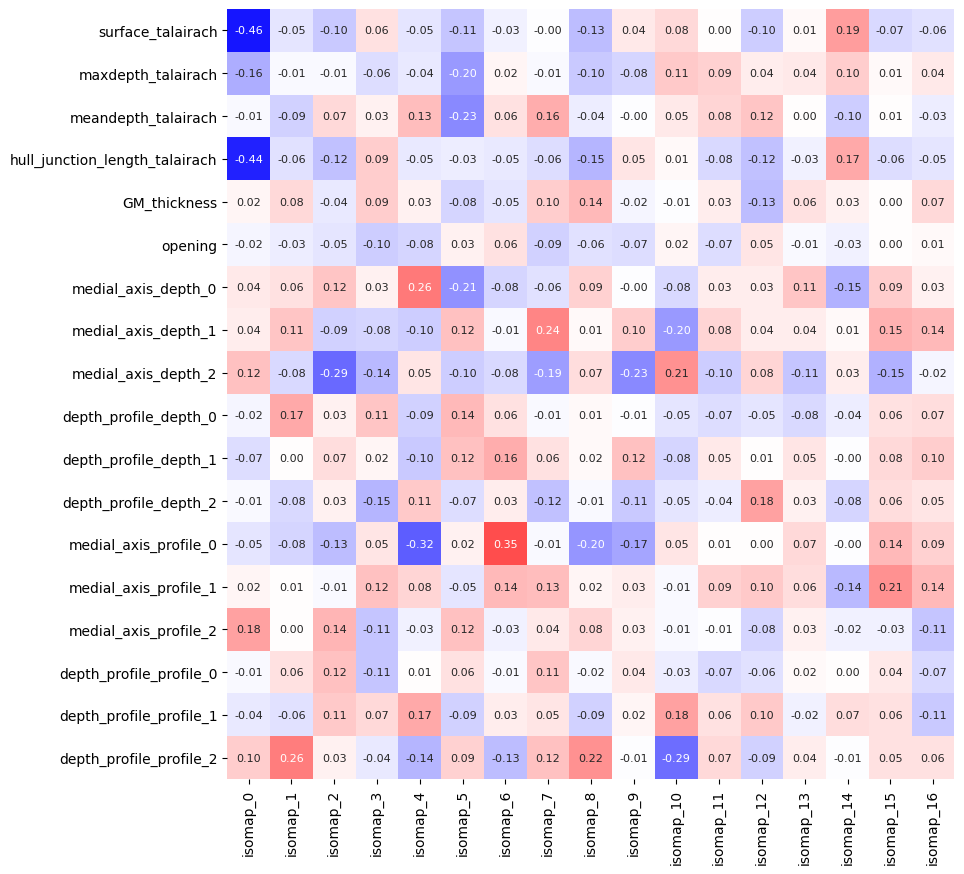

In [111]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr_df.iloc[:17, 17:].T, cmap='seismic', vmax=1, vmin=-1, ax=ax, square=True,
            annot=True, fmt='.2f', annot_kws={'fontsize': 11}, cbar=False)
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight',
            pad_inches=0.0)

/tmp/ipykernel_2929398/1192220385.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df2 = all_feat_df.corr()


<Axes: >

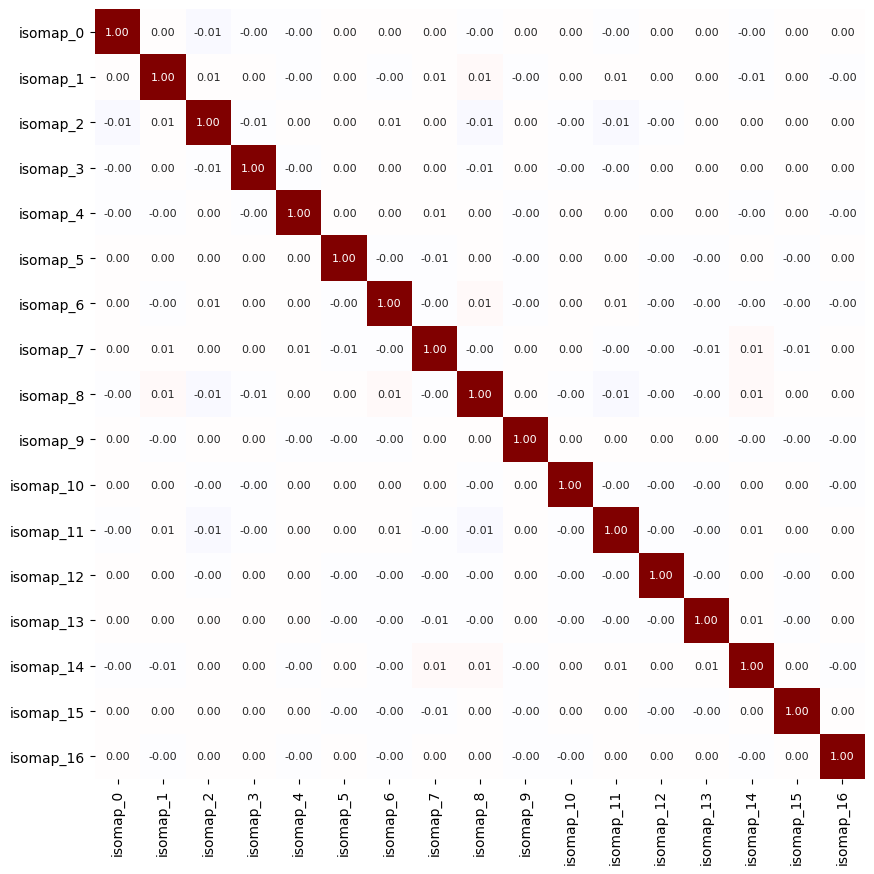

In [157]:
corr_df2 = all_feat_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr_df2.iloc[:17, :17], cmap='seismic', vmax=1, vmin=-1, ax=ax, square=True,
            annot=True, fmt='.2f', annot_kws={'fontsize': 8}, cbar=False)

/tmp/ipykernel_2929398/229210206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'group'] = scatter_df.group.replace({1:'FHR-BP', 2:'FHR-SZ', 3:'Control'})


R2: -9.396403880574951


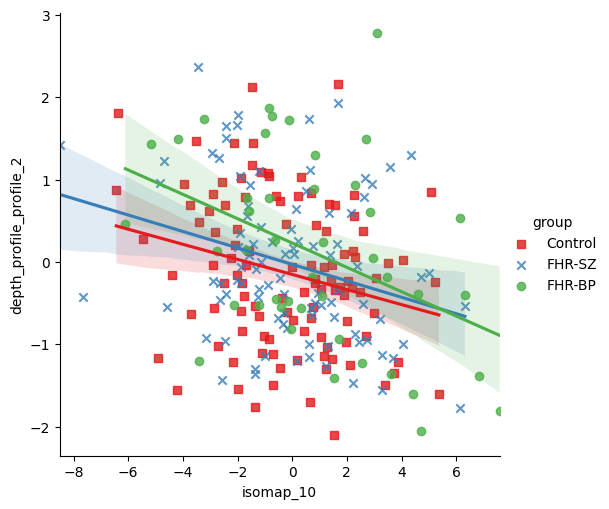

In [144]:

scatter_df = all_feat_df[all_feat_df.subject_id.isin(bv_good_subj)]
scatter_df.loc[:, 'group'] = scatter_df.group.replace({1:'FHR-BP', 2:'FHR-SZ', 3:'Control'})
sns.lmplot(data=scatter_df, x='isomap_10', y='depth_profile_profile_2', hue='group',
                palette='Set1', markers = ["s", "x", "o"])
print(f'R2: {r2_score(scatter_df.medial_axis_profile_0, scatter_df.isomap_6)}')
# plt.legend(['FHR-BP', 'FHR-SZ', 'Control'])

In [115]:
scatter_df.columns

Index(['isomap_0', 'isomap_1', 'isomap_2', 'isomap_3', 'isomap_4', 'isomap_5',
       'isomap_6', 'isomap_7', 'isomap_8', 'isomap_9', 'isomap_10',
       'isomap_11', 'isomap_12', 'isomap_13', 'isomap_14', 'isomap_15',
       'isomap_16', 'subject_id', 'side', 'handedness', 'group', 'cbcl_total',
       'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis', 'sex',
       'surface_talairach', 'maxdepth_talairach', 'meandepth_talairach',
       'hull_junction_length_talairach', 'GM_thickness', 'opening',
       'medial_axis_depth_0', 'medial_axis_depth_1', 'medial_axis_depth_2',
       'depth_profile_depth_0', 'depth_profile_depth_1',
       'depth_profile_depth_2', 'medial_axis_profile_0',
       'medial_axis_profile_1', 'medial_axis_profile_2',
       'depth_profile_profile_0', 'depth_profile_profile_1',
       'depth_profile_profile_2'],
      dtype='object')

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, ttest_ind

#### Select only righ-handed individuals

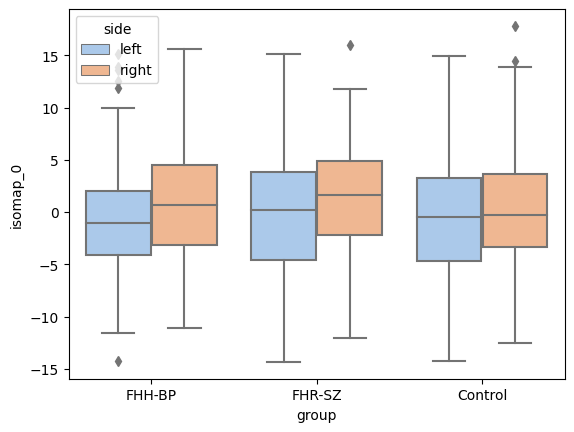

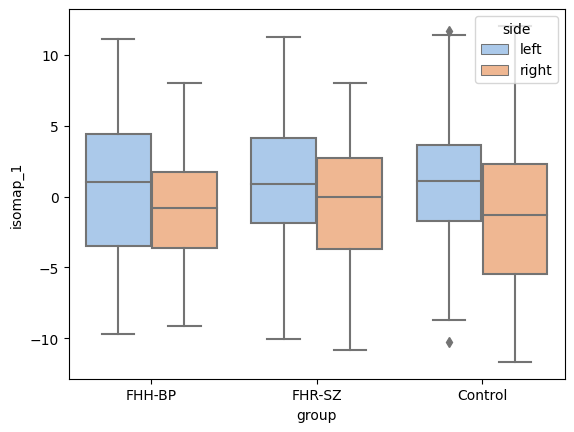

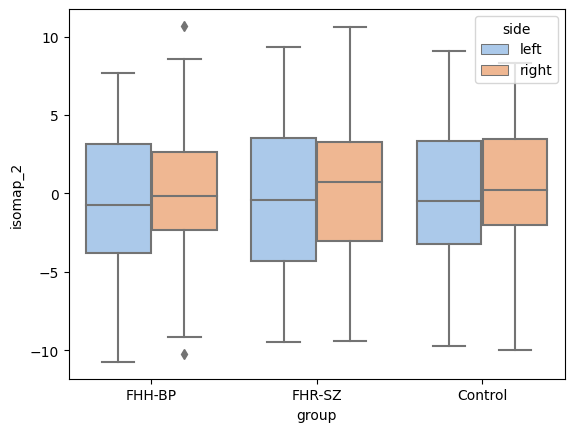

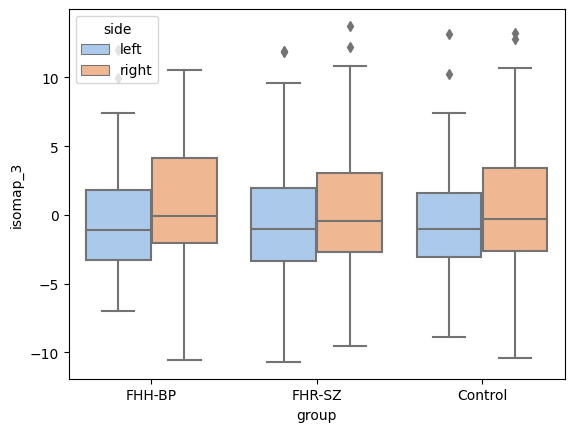

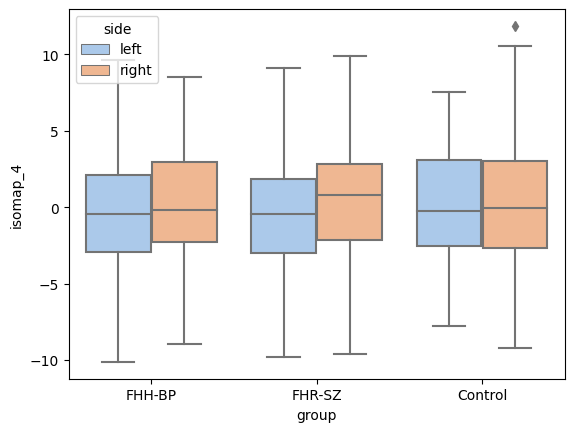

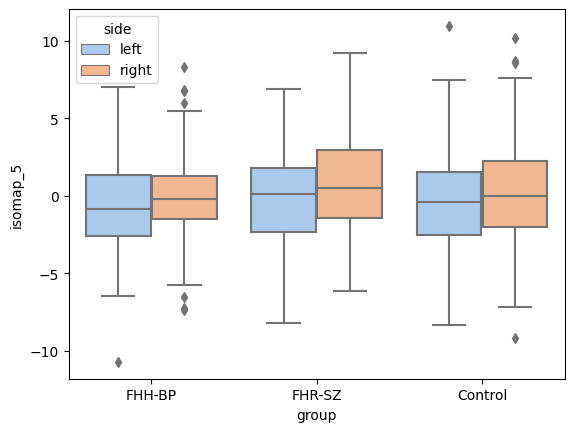

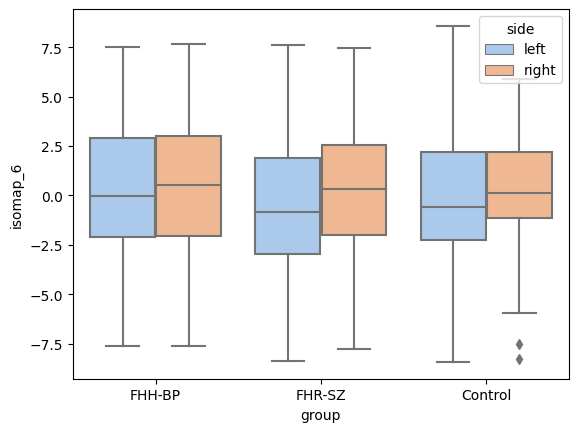

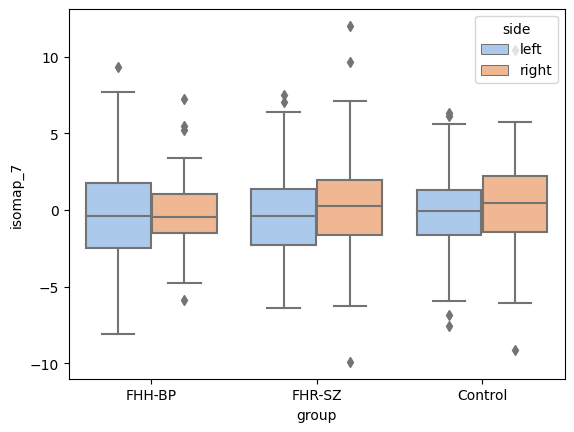

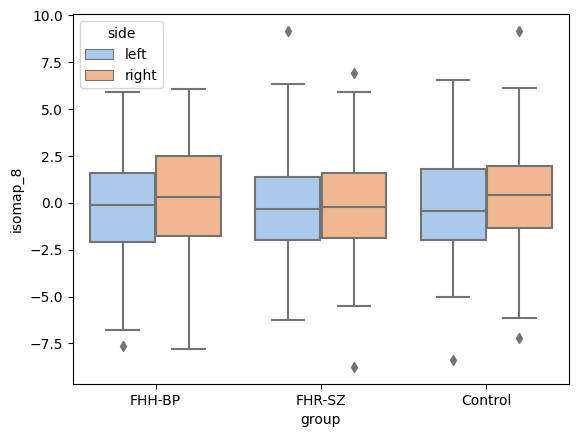

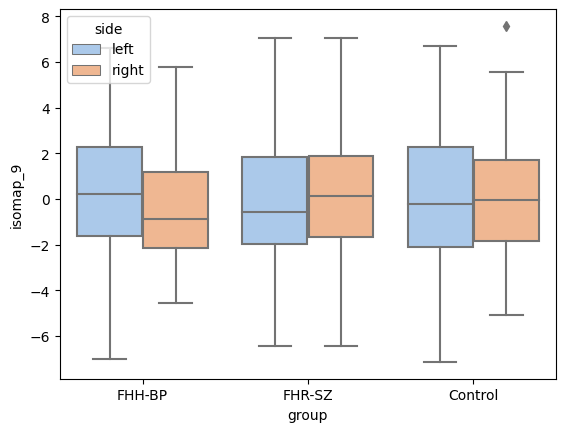

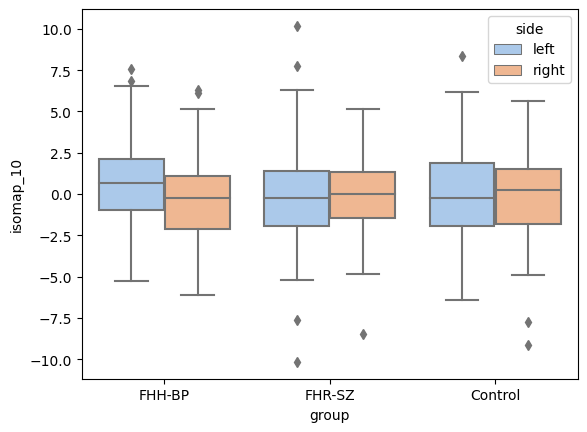

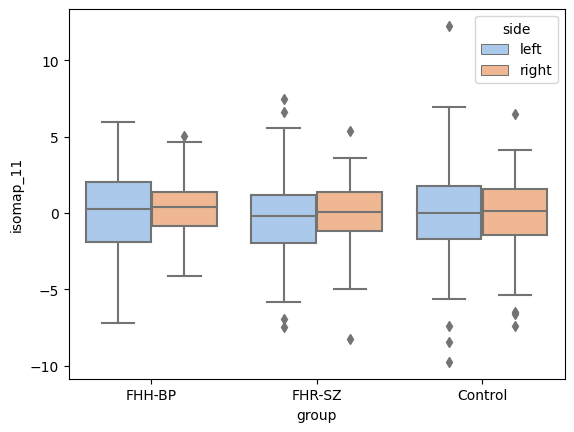

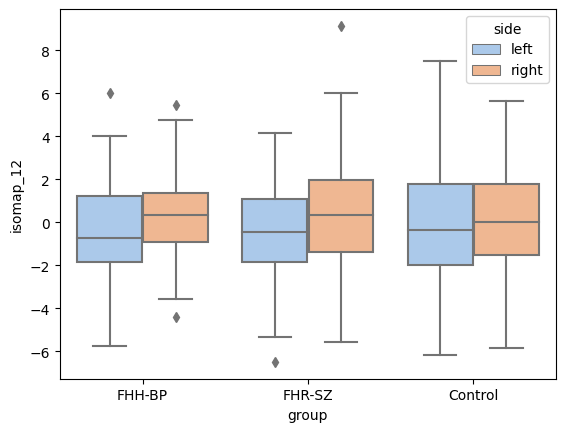

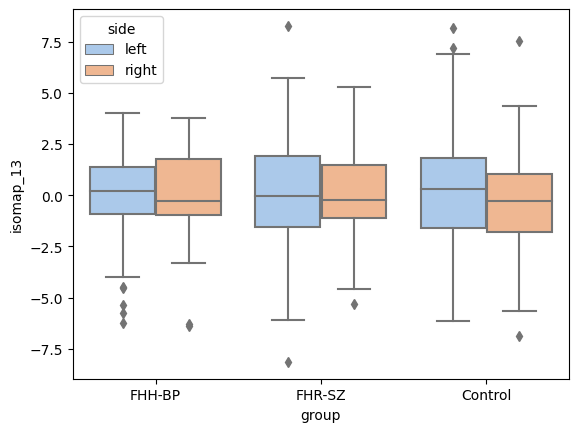

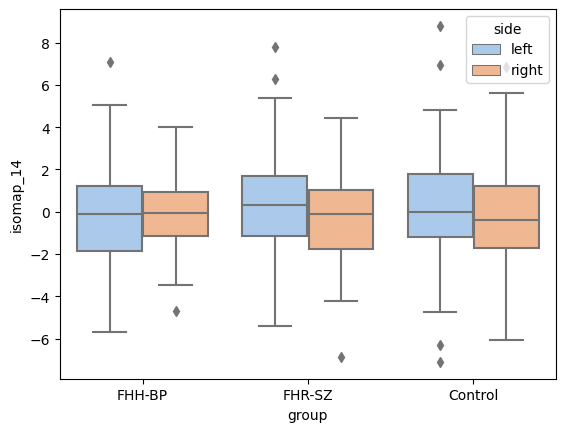

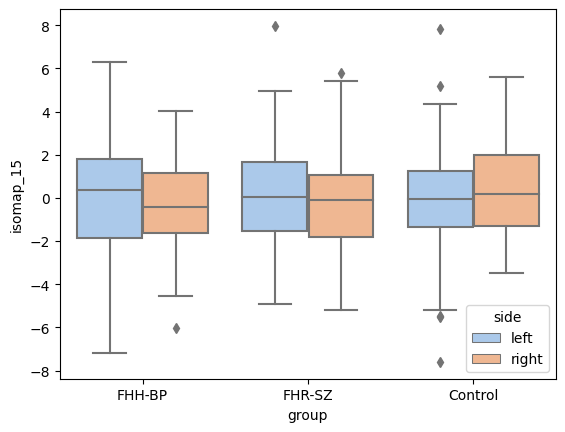

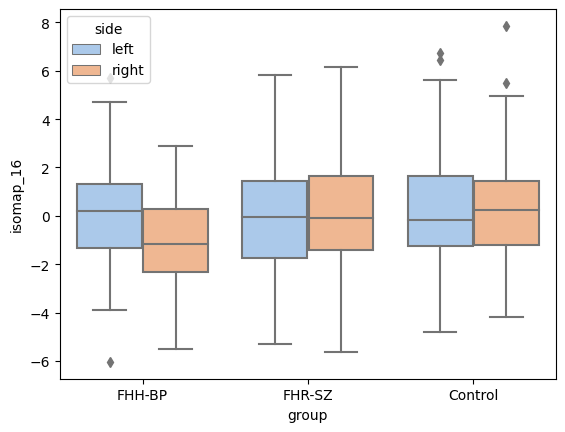

In [16]:
for id in isomap_features.columns[:-2]:
    sns.boxplot(x='group', y=id, hue='side', data=all_feat_df, palette='pastel')
    # sns.stripplot(data=all_feat_df, x='group', y='isomap_0', hue='side', palette='muted')
    plt.xticks([0, 1, 2], ['FHH-BP', 'FHR-SZ', 'Control'])
    plt.show()

In [17]:
split = StratifiedKFold(10, shuffle=True, random_state=43)
splits = split.split(np.zeros_like(eda_df.group.values), eda_df.group.values)

In [70]:
def unwrap_side_feat(subj_df, sided_feat_names, not_sided_feat_names):
    left_f = {'l_'+k:v.values.item() for k,v in subj_df[subj_df.side == 'left'][sided_feat_names].items()}
    rigt_f = {'r_'+k:v.values.item() for k,v in subj_df[subj_df.side == 'right'][sided_feat_names].items()}
    for f in not_sided_feat_names:
        rigt_f[f] = subj_df[f].values[0]
    subj_feat = {**left_f, **rigt_f}
    subj_feat['subject_id'] = subj_df.subject_id.values[0]
    return subj_feat
    
sided_feat_names = ['isomap_0', 'isomap_1', 'isomap_2', 'isomap_3', 'isomap_4', 'isomap_5',
       'isomap_6', 'isomap_7', 'isomap_8', 'isomap_9', 'isomap_10',
       'isomap_11', 'isomap_12', 'isomap_13', 'isomap_14', 'isomap_15',
       'isomap_16']

not_sided_feat_names = ['sex', 'handedness', 'group', ]

In [71]:
metrics = []

for train_idxs, test_idxs in splits:
    train_subjects = eda_df.iloc[train_idxs].index.values
    test_subjects = eda_df.iloc[test_idxs].index.values
    
    train_df = []
    test_df = []
    for s in train_subjects:
        if s in all_feat_df.subject_id.values:
            train_df.append(unwrap_side_feat(all_feat_df[all_feat_df.subject_id == s],
                                            sided_feat_names,
                                            not_sided_feat_names))
        # else:
        #     print(f'Subject {s} not found in the dataset')
    for s in test_subjects:
        if s in all_feat_df.subject_id.values:
            test_df.append(unwrap_side_feat(all_feat_df[all_feat_df.subject_id == s],
                                            sided_feat_names,
                                            not_sided_feat_names))
        # else:
        #     print(f'Subject {s} not found in the dataset')
    train_df = pd.DataFrame(train_df).set_index('subject_id')   
    test_df = pd.DataFrame(test_df).set_index('subject_id')   
    
    break

In [72]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [73]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_split=10, min_samples_leaf=10)
# dt  = LogisticRegression(max_iter=1000, C=10000)
# dt = RandomForestClassifier(max_depth=4,
#                             n_estimators=1000,
#                             min_samples_split=5)
# dt = SVC(kernel='rbf', C=.5, probability=False)
dt.fit(train_df.drop(columns=['group']), train_df.group)
train_pred = dt.predict(train_df.drop(columns=['group']))
test_pred = dt.predict(test_df.drop(columns=['group']))
train_bacc = balanced_accuracy_score(train_df.group, train_pred)
test_bacc = balanced_accuracy_score(test_df.group, test_pred)
print(f'Train BACC: {train_bacc}')
print(f'Test BACC: {test_bacc}')

Train BACC: 0.6050829936794849
Test BACC: 0.34259259259259256


In [60]:
subj_df = all_feat_df[all_feat_df.subject_id == train_subjects[0]]
subj_df

,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,isomap_8,isomap_9,...,medial_axis_depth_2,depth_profile_depth_0,depth_profile_depth_1,depth_profile_depth_2,medial_axis_profile_0,medial_axis_profile_1,medial_axis_profile_2,depth_profile_profile_0,depth_profile_profile_1,depth_profile_profile_2
0,9.820317,-1.009474,-0.425166,-1.845629,-1.515154,0.022458,3.377352,-1.070259,-1.583626,-1.259222,...,0.160410,0.051990,0.399175,1.490308,3.073189,1.421125,-0.882544,-0.094356,-0.613653,0.618203
1,14.504303,-2.307756,-3.038601,-0.050787,-5.993755,-0.815435,3.753596,-4.520578,-4.452836,1.816741,...,-1.279857,-0.283331,0.436842,-0.339570,4.073485,-0.355884,-0.633154,-0.005550,-0.570127,0.485782


Try to estimate classification performance on sulci shape only, test (cbl) and both to see if sulci shape adds anything to the classification performance.

Look at the top important features


Having less features (only from right sulci) improves the performance of the model

In [255]:
all_feat_df.columns

Index(['isomap_0', 'isomap_1', 'isomap_2', 'isomap_3', 'isomap_4', 'isomap_5',
       'isomap_6', 'isomap_7', 'isomap_8', 'isomap_9', 'isomap_10',
       'isomap_11', 'isomap_12', 'isomap_13', 'isomap_14', 'isomap_15',
       'isomap_16', 'subject_id', 'side', 'handedness', 'group', 'cbcl_total',
       'cbcl_external', 'cbcl_internal', 'cgas', 'any_diagnosis', 'sex',
       'surface_talairach', 'maxdepth_talairach', 'meandepth_talairach',
       'hull_junction_length_talairach', 'GM_thickness', 'opening',
       'medial_axis_depth_0', 'medial_axis_depth_1', 'medial_axis_depth_2',
       'depth_profile_depth_0', 'depth_profile_depth_1',
       'depth_profile_depth_2', 'medial_axis_profile_0',
       'medial_axis_profile_1', 'medial_axis_profile_2',
       'depth_profile_profile_0', 'depth_profile_profile_1',
       'depth_profile_profile_2'],
      dtype='object')

0.0